# The effect of aging on running performance

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime, date, time
import matplotlib.pyplot as plt

### Read data

In [2]:
#hm1 = pd.read_excel('assets/2018.xlsx')
#hm2 = pd.read_excel('assets/2019.xlsx')
#dif = 1 

hm1 = pd.read_excel('assets/2017.xlsx')
hm2 = pd.read_excel('assets/2022.xlsx')
dif = 5

def cleanup(df):
    df = df[~df['Name'].isna()] # remove empty name
    df = df[~df['Category'].isin(['KFH','MFH',np.NaN])] # remove empty category
    df = df[~df['Name'].duplicated()] # remove duplicate name
    
    def split(row):
        category = row['Category']
        gender = category[0:1]
        ageFrom = int(category[1:3])
        ageTo = int(category[4:6])
        age = (ageFrom+ageTo+1)/2
        return gender, ageFrom, ageTo, age
        
    df[['Gender','From','To', 'Age']] = df.apply(split, axis=1, result_type='expand')
    df['Minutes'] = df.apply(lambda x: (datetime.combine(date.min, x['Time']) - datetime.min).total_seconds()/60, axis=1)
    
    return df[['Name','Gender','From','To','Age','Minutes']]
    
hm1=cleanup(hm1)
hm2=cleanup(hm2)
hm1.head()

,Name,Gender,From,To,Age,Minutes
0,Okubamichael Fissehatsion,M,24,34,29.5,64.750000
1,Zerei Kbrom Mezngi,M,24,34,29.5,64.900000
2,Senay Fissehatsion,M,22,23,23.0,65.466667
3,Marius Vedvik,M,24,34,29.5,65.866667
4,Eivind Øygard,M,24,34,29.5,66.583333


### Join results from two years by runner name

In [3]:
hm = pd.merge(hm1, hm2, how='inner', left_on='Name', right_on='Name', suffixes=('_1', '_2'))
hm['Improvement'] = hm.apply(lambda x : (x['Minutes_1']-x['Minutes_2']), axis=1)

hm = hm[hm['From_1']<=hm['From_2']] # remove those who became younger
hm = hm[hm['From_2']<=hm['To_1']+dif] # remove those who too old
hm.head()

,Name,Gender_1,From_1,To_1,Age_1,Minutes_1,Gender_2,From_2,To_2,Age_2,Minutes_2,Improvement
0,Marius Vedvik,M,24,34,29.5,65.866667,M,24,34,29.5,67.833333,-1.966667
1,Michael Ande Tesfamichael,M,24,34,29.5,72.933333,M,24,34,29.5,74.516667,-1.583333
3,Kjetil Andre Bjerkrheim,M,24,34,29.5,76.400000,M,24,34,29.5,80.916667,-4.516667
4,Runa Skrove Falch,K,24,34,29.5,76.500000,K,24,34,29.5,79.950000,-3.450000
5,Magnus Warvik,M,22,23,23.0,78.300000,M,24,34,29.5,82.983333,-4.683333


### Remove outliers (1%)

In [4]:
def remove_pct(df, f, q):
    qmin = df[f].quantile(q/2)
    qmax = df[f].quantile(1-q/2)
    return df[(df[f]>=qmin) & (df[f]<=qmax)]
    
hm = remove_pct(hm, 'Improvement', 0.01)

### Remove groups with lack of data

In [5]:
size = hm.groupby('Age_1')['Improvement'].size()
size = size[size>5]
hm = hm[(hm['Age_1']>=size.index.min()) & (hm['Age_1']<=size.index.max())]

### Target

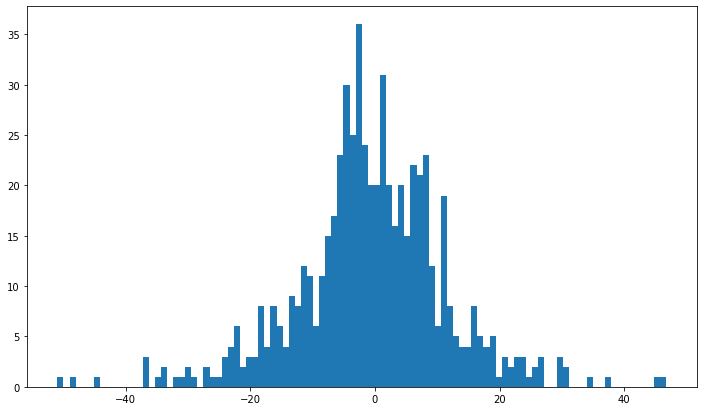

-0.5953355155482826 12.172613397034198


In [6]:
plt.subplots(figsize=(12, 7))
plt.hist(hm['Improvement'], bins=100)
plt.show()

print(hm['Improvement'].mean(), hm['Improvement'].std())

### Regression

In [7]:
X = hm[['Age_1']]
Y = hm['Improvement']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
a = model.params[1]
b = model.params[0]

print(model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.042    
Dependent Variable: Improvement      AIC:                4763.6981
Date:               2023-01-13 23:48 BIC:                4772.5283
No. Observations:   611              Log-Likelihood:     -2379.8  
Df Model:           1                F-statistic:        27.78    
Df Residuals:       609              Prob (F-statistic): 1.89e-07 
R-squared:          0.044            Scale:              141.94   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const       9.1827     1.9168    4.7906   0.0000    5.4183   12.9471
Age_1      -0.2302     0.0437   -5.2705   0.0000   -0.3159   -0.1444
------------------------------------------------------------------
Omnibus:              47.145       Durbin-Watson:          2.078  
Pro

In [8]:
ci = model.conf_int()

def minmaxci(x):
    miny = maxy = x*ci.iloc[1,0]+ci.iloc[0,0]
    for i in range(2):
        for j in range(2):
            y = x*ci.iloc[1,i]+ci.iloc[0,j]
            miny = np.minimum(miny, y)
            maxy = np.maximum(maxy, y)
    return miny, maxy

### Chart

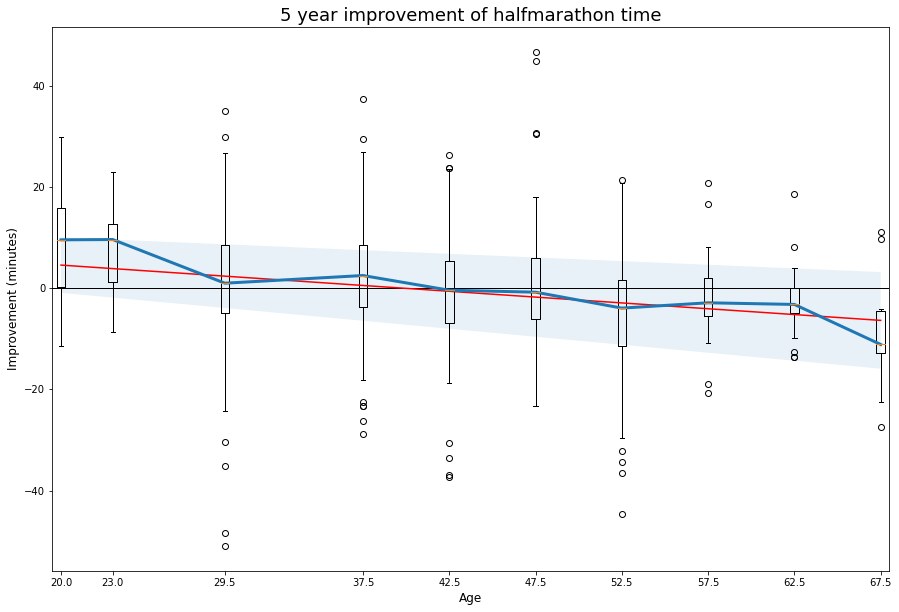

In [9]:
median = hm.groupby('Age_1')['Improvement'].median()
x = median.index
hma = list()
for age in x:
    hma.append(hm[hm['Age_1']==age]['Improvement'])
    
plt.figure(figsize=(15, 10))
plt.title(f'{dif} year improvement of halfmarathon time', fontsize=18)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Improvement (minutes)', fontsize=12)
plt.boxplot(hma, positions=x)
plt.axhline(y=0, linewidth=1, color='k')
plt.plot(x, x*a+b, color='r')
plt.fill_between(x, *minmaxci(x), alpha=0.1)
plt.plot(x, median, linewidth=3)
plt.show()

### Result time by age

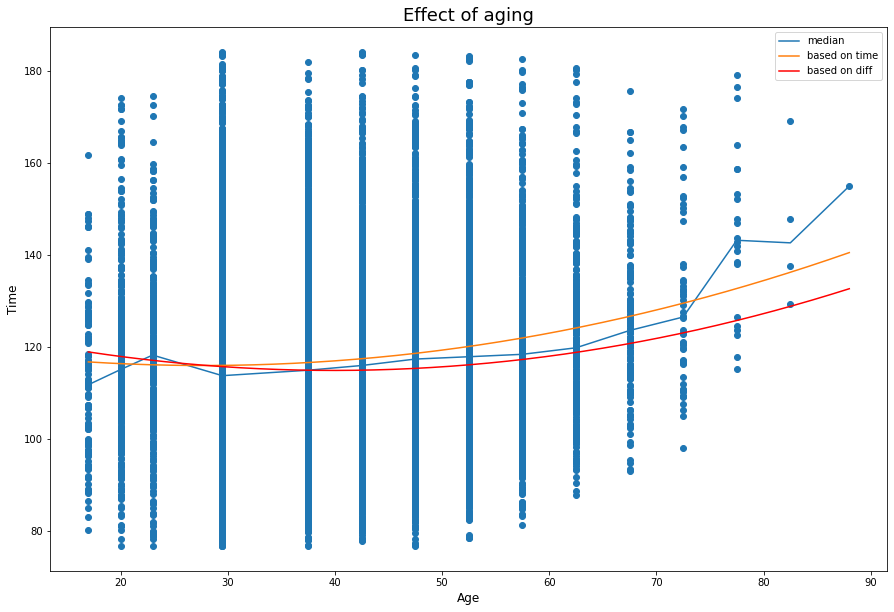

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

hm0 = pd.concat([hm1, hm2])
hm0 = remove_pct(hm0, 'Minutes', 0.01)

median = hm0.groupby('Age')['Minutes'].median()
x = median.index

x0 = x[4]
scale = dif * (dif + 1) / 2
const = (x0 * x0 * a / 2 + b * x0)/scale + median.iloc[4]
xp = np.linspace(x.min(), x.max(), 1000)
yp = const - (xp * xp * a / 2 + b * xp)/scale

m = make_pipeline(PolynomialFeatures(2),LinearRegression())
m.fit(hm0[['Age']], hm0['Minutes'])
y2 = m.predict(pd.DataFrame({'Age': xp}))

plt.figure(figsize=(15, 10))
plt.title('Effect of aging', fontsize=18)
plt.scatter(hm0['Age'], hm0['Minutes'])
plt.xlabel('Age', fontsize=12)
plt.ylabel('Time', fontsize=12)
plt.plot(x, median, label='median')
plt.plot(xp, y2, label='based on time')
plt.plot(xp, yp, c='r', label='based on diff')
plt.legend()
plt.show()